In [ ]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import wandb

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.utils import data


import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import functools
from tqdm import tqdm
from datetime import datetime
import numpy as np
from core.datasets.vqa_motion_dataset import VQMotionDataset,DATALoader,VQVarLenMotionDataset,MotionCollator,VQFullMotionDataset
from einops import rearrange, reduce, pack, unpack
import librosa

In [15]:
lens = []
long_pths = []
pths = glob("/srv/scratch/sanisetty3/music_motion/AIST/new_joint_vecs/*.npy")
for i in tqdm(pths):
    mot = np.load(i)
    lens.append(mot.shape[0])
    if mot.shape[0] > 600:
        long_pths.append(i)
        


In [17]:
len(long_pths)

318

In [16]:
np.mean(lens)/20

13.145267791636096

## Our method

In [4]:
from utils.motion_process import recover_from_ric
import visualize.plot_3d_global as plot_3d
from glob import glob
def to_xyz(motion, mean ,std , j = 22):
    motion_xyz = recover_from_ric(motion.cpu().float()*std+mean, j)
    motion_xyz = motion_xyz.reshape(motion.shape[0],-1, j, 3)
    return motion_xyz

            
def sample_render(motion_xyz , name , save_path):
    print(f"render start")
    
    gt_pose_vis = plot_3d.draw_to_batch(motion_xyz.numpy(),None, [os.path.join(save_path,name + ".gif")])



In [10]:
from configs.config import cfg, get_cfg_defaults
from core.models.vqvae import VQMotionModel
from core.models.motion_regressor import MotionRegressorModel

cfg_vq = get_cfg_defaults()
cfg_vq.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/configs/var_len_768_768_aist_vq.yaml")


cfg_trans = get_cfg_defaults()
cfg_trans.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/configs/var_len_768_768_aist.yaml")



In [11]:
vqvae_model = VQMotionModel(cfg_vq.vqvae).eval()
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768_mix/vqvae_motion_best_fid.pt", map_location = 'cpu')
print(pkg["steps"])
vqvae_model.load_state_dict(pkg["model"])
vqvae_model =vqvae_model.cuda()


tensor([295000.])


In [18]:
trans_model = MotionRegressorModel(args = cfg_trans.motion_trans ,pad_value=1025 ).eval()
pkg_trans = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/generator/var_len/trans_768_768_albi_aist/trans_motion_best_fid.pt", map_location = 'cpu')
print(pkg_trans["steps"])
trans_model.load_state_dict(pkg_trans["model"])
trans_model =trans_model.cuda()


tensor([195000.])


In [ ]:
os.makedirs("/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/generator/var_len/trans_768_768_albi_aist/", exist_ok=True)

## Motion generation

In [20]:
from core.datasets.vqa_motion_dataset import MotionCollatorConditional,VQVarLenMotionDatasetConditional, TransMotionDatasetConditional,TransMotionDatasetConditionalFull
from utils.eval_music import evaluate_music_motion_vqvae, evaluate_music_motion_trans,get_target_indices


In [110]:
def process_gen_output(gen_motion_indices , seq_len):
    eos_index = (gen_motion_indices == 1026).nonzero().flatten().tolist()
    # print(eos_index)
    pad_index = (gen_motion_indices == 1025).nonzero().flatten().tolist()
    # print(pad_index)
    bos_index = (gen_motion_indices == 1024).nonzero().flatten().tolist()
    # print(bos_index)
    stop_index = min([*eos_index , *pad_index , *bos_index, seq_len])

    gen_motion_indices_ = gen_motion_indices[:int(stop_index)]

    return gen_motion_indices_


In [111]:
def get_target_indices2(batch , trans_model , sample_max = False , bos = 1024,pad = 1025,eos = 1026):
##batch size = 1

    inp, target = batch["motion"][:, :-1], batch["motion"][:, 1:]
    # print(target.shape)

    ##inp: b seqlen-1 target: b seqlen-1
    length = int(batch["motion_lengths"][0])
    # print(length)

    logits = trans_model(motion = inp.cuda() , mask = batch["motion_mask"][:,:-1].cuda()  , \
        context = batch["condition"].cuda(), context_mask = batch["condition_mask"].cuda())

    probs = torch.softmax(logits[0][:length], dim=-1)
    if sample_max:
        _, cls_pred_index = torch.max(probs, dim=-1)

    else:
        dist = torch.distributions.Categorical(probs)
        cls_pred_index = dist.sample()
    # print(cls_pred_index.shape)


    ## cls_pred_index - list

    eos_index = (cls_pred_index == eos).nonzero().flatten().tolist()
    # print(eos_index)
    pad_index = (cls_pred_index == pad).nonzero().flatten().tolist()
    # print(pad_index)
    bos_index = (cls_pred_index == bos).nonzero().flatten().tolist()
    # print(bos_index)
    stop_index = min([*eos_index , *pad_index , *bos_index, length-1])

    gen_motion_indices_ = cls_pred_index[:int(stop_index)]
    gt_motion_indices_ = target[target<bos]

    # print(gen_motion_indices_.dtype , gt_motion_indices_.dtype)


    gen_motion_indices_ = (gen_motion_indices_).contiguous().view(1,-1)
    gt_motion_indices_ = gt_motion_indices_.contiguous().view(1,-1)
    # print(gen_motion_indices_.shape,gt_motion_indices_.shape)


    return gen_motion_indices_ , gt_motion_indices_

In [19]:
train_ds = TransMotionDatasetConditionalFull("aist", split = "test",data_root = "/srv/scratch/sanisetty3/music_motion/AIST" , datafolder="joint_indices_max_400", window_size = -1)


NameError: name 'TransMotionDatasetConditionalFull' is not defined

In [12]:
collate_fn2 = MotionCollatorConditional(dataset_name = "aist" , bos = 1024, pad = 1025, eos = 1026)


In [13]:
dl = DATALoader(train_ds , batch_size = 1,collate_fn=collate_fn2)


In [177]:
for reg_batch in dl:
    break
for k,v in reg_batch.items():
    print(k , v.shape)
    try:
        v = v.cuda()
    except:
        continue

motion torch.Size([1, 192])
motion_lengths torch.Size([1])
motion_mask torch.Size([1, 192])
names (1,)
condition torch.Size([1, 191, 128])
condition_mask torch.Size([1, 191])


In [178]:
music_name = str(reg_batch["names"]).split("_")[-2]
music_encoding=  np.load(os.path.join("/srv/scratch/sanisetty3/music_motion/AIST/music" , music_name + ".npy"))

In [185]:
music_name

'mKR2'

In [15]:
inp, target = reg_batch["motion"][:, :-1], reg_batch["motion"][:, 1:]

In [43]:
inp[:,:1].shape

torch.Size([1, 1])

In [114]:
gen_motion_indices , gt_motion_indices = get_target_indices2(reg_batch , trans_model)

In [115]:
gen_motion_indices.shape

torch.Size([1, 140])

In [180]:
gen_motion_indices = inp[:,:1]
while gen_motion_indices.shape[1]<=800:
        gen_motion_indices = trans_model.generate(start_tokens =gen_motion_indices.cuda(),\
                                              seq_len=400 , \
                                              context = torch.Tensor(music_encoding)[None,...].cuda(), \
                                            context_mask=torch.ones((1 ,music_encoding.shape[0]) , dtype = torch.bool).cuda()
                                              )
        gen_motion_indices = gen_motion_indices[gen_motion_indices<1024][None,...]
        print(gen_motion_indices.shape[1])

100%|██████████| 400/400 [00:08<00:00, 45.15it/s]


401


100%|██████████| 400/400 [00:10<00:00, 39.56it/s]

801


In [181]:
gen_motion_indices = gen_motion_indices[gen_motion_indices<1024][None,...]

In [182]:
gen_motion_indices.shape

torch.Size([1, 801])

In [98]:
inp[:,:1]

torch.Size([1, 1])

In [103]:
torch.randint(0 , 1024 , (1,1))

tensor([[958]])

In [184]:
os.path.basename(musics[0])

'mWA0.npy'

In [183]:
quant , out_motion = vqvae_model.decode(gen_motion_indices.cuda())
# np.save(os.path.join(save_pth , music_name+".npy" ,) , out_motion.cpu().numpy())

sample_render(to_xyz(out_motion[0:1].detach().cpu(),mean = train_ds.mean , std = train_ds.std), name = music_name+"_full" , save_path = "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals")


render start


In [ ]:
sample_render(to_xyz(out_motion[0:1].detach().cpu(),mean = train_ds.mean , std = train_ds.std), name = music_name+"_full" , save_path = "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals")


## Generate 20s and save gen + gt

In [1]:
gt_path = "/srv/scratch/sanisetty3/music_motion/AIST/joint_indices_max_400/*"

In [6]:
gts = glob(gt_path)

In [7]:
gts[0]

'/srv/scratch/sanisetty3/music_motion/AIST/joint_indices_max_400/gBR_sFM_cAll_d06_mBR4_ch20.npy'

In [8]:
from itertools import groupby

a = gts

def get_domain(path):
    # Example: 'www.google.com' -> 'google.com'
    return '.'.join(os.path.basename(path).split(".")[0].split('_')[-2])

def choose_item(iterable):
    # Ex. input: ['www.google.com', 'google.com',  'www.google.com']
    # Ex. output: 'www.google.com' (longest string)
    return sorted(iterable, key=lambda x: -len(x))[0]

results = []
for domain,grp in groupby(sorted(a, key=get_domain), key=get_domain):
    results.append(choose_item(grp))


In [9]:
gt_motion_indices_path = results
len(gt_motion_indices_path)

60

In [12]:
sve_txt = 

In [18]:
with open("/srv/scratch/sanisetty3/music_motion/AIST/gt60.txt", 'w') as f:
    for row in gt_motion_indices_path:
        f.write(os.path.basename(row)[2:] + '\n')

In [10]:
def get_motion(music):
    for i in gt_motion_indices_path:
        if os.path.basename(i).split(".")[0].split('_')[-2] == music:
            return i

In [16]:
os.path.join("/srv/scratch/sanisetty3/music_motion/AIST/new_joint_vecs" , os.path.basename(gt_motion_indices_path[0]))

'/srv/scratch/sanisetty3/music_motion/AIST/new_joint_vecs/M_gBR_sBM_cAll_d04_mBR0_ch01.npy'

In [34]:
lst = []
with open("/srv/scratch/sanisetty3/music_motion/AIST/gt60.txt", 'r') as f:
    for line in f:
        lst.append(line.strip().split(".")[0] )

In [36]:
lst

['gBR_sBM_cAll_d04_mBR0_ch01',
 'gBR_sBM_cAll_d05_mBR1_ch05',
 'gBR_sBM_cAll_d04_mBR2_ch05',
 'gBR_sBM_cAll_d04_mBR3_ch04',
 'gBR_sBM_cAll_d06_mBR4_ch05',
 'gBR_sBM_cAll_d06_mBR5_ch04',
 'gHO_sBM_cAll_d20_mHO0_ch10',
 'gHO_sBM_cAll_d19_mHO1_ch09',
 'gHO_sFM_cAll_d19_mHO2_ch03',
 'gHO_sBM_cAll_d21_mHO3_ch10',
 'gHO_sBM_cAll_d20_mHO4_ch05',
 'gHO_sBM_cAll_d21_mHO5_ch01',
 'gJB_sBM_cAll_d08_mJB0_ch05',
 'gJB_sBM_cAll_d08_mJB1_ch03',
 'gJB_sBM_cAll_d09_mJB2_ch04',
 'gJB_sBM_cAll_d07_mJB3_ch10',
 'gJB_sBM_cAll_d08_mJB4_ch10',
 'gJB_sBM_cAll_d09_mJB5_ch02',
 'gJS_sBM_cAll_d02_mJS0_ch09',
 'gJS_sBM_cAll_d02_mJS1_ch06',
 'gJS_sBM_cAll_d03_mJS2_ch06',
 'gJS_sBM_cAll_d01_mJS3_ch01',
 'gJS_sBM_cAll_d02_mJS4_ch04',
 'gJS_sBM_cAll_d03_mJS5_ch10',
 'gKR_sFM_cAll_d30_mKR0_ch15',
 'gKR_sBM_cAll_d28_mKR1_ch09',
 'gKR_sBM_cAll_d30_mKR2_ch01',
 'gKR_sFM_cAll_d30_mKR3_ch18',
 'gKR_sBM_cAll_d29_mKR4_ch08',
 'gKR_sBM_cAll_d29_mKR5_ch07',
 'gLH_sBM_cAll_d16_mLH0_ch10',
 'gLH_sBM_cAll_d16_mLH1_ch07',
 'gLH_sB

In [4]:
import plotly
import plotly.express as px
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
genre_dict = {
    "mBR" : "Break",
    "mPO" : "Pop",
    "mLO" : "Lock",
    "mMH" : "Middle Hip-hop",
    "mLH" : "LA style Hip-hop",
    "mHO" : "House",    
    "mWA" : "Waack",
    "mKR" : "Krump",
    "mJS" : "Street Jazz",
    "mJB" : "Ballet Jazz",
}

In [21]:
motions = []
musics = []
min_len = 1000
for i in gt_motion_indices_path:
    motion = (np.load(os.path.join("/srv/scratch/sanisetty3/music_motion/AIST/new_joint_vecs",os.path.basename(i))))
    if motion.shape[0] < min_len:
        min_len = motion.shape[0]
        
    musics.append(genre_dict[os.path.basename(i).split(".")[0].split('_')[-2][:3]])
    
    motions.append(motion[:141,:])
    

In [ ]:
motions = np.stack(motions)

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto' , n_iter = 10000).fit_transform(motions.reshape(len(motions),-1))


In [ ]:
plt.figure(figsize = (12,12))
g1 = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = musics, palette = "bright" , legend = True)
g1.set(title='Ground Truth Motions')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.set(yticklabels=[])
g1.set(ylabel=None)
plt.legend( frameon=False)
plt.tick_params(bottom=False , left = False) 
plt.show()

In [92]:
motions_list = glob("/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/generator/var_len/trans_768_768_albi_aist/*.npy")

In [93]:
motions_list[0]

'/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/generator/var_len/trans_768_768_albi_aist/mWA3.npy'

In [113]:
name =os.path.basename( motions_list[2]).split(".")[0]
motion = np.load(motions_list[0])

In [119]:
name

'mHO4'

In [114]:
motion_xyz = to_xyz(torch.Tensor(motion) , mean=train_ds.mean , std = train_ds.std)

In [120]:
np.save(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/{name}.npy" , motion_xyz[0])

In [94]:
motions2 = []
musics2 = []
min_len2 = 1000
for i in gt_motion_indices_path:
    music_name = os.path.basename(i).split(".")[0].split('_')[-2]
    motion = (np.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/generator/var_len/trans_768_768_albi_aist/{music_name}.npy"))[0]
#     print(motion.shape)
    if motion.shape[0] < min_len2:
        min_len2 = motion.shape[0]
        
    musics2.append(genre_dict[music_name[:3]])
    
    motions2.append(motion[:141,:])
motions2 = np.stack(motions)

In [95]:
motions.shape

(60, 141, 263)

In [104]:
X_embedded = TSNE(n_components=2, learning_rate='auto' , n_iter = 10000).fit_transform(motions.reshape(len(motions),-1))


/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


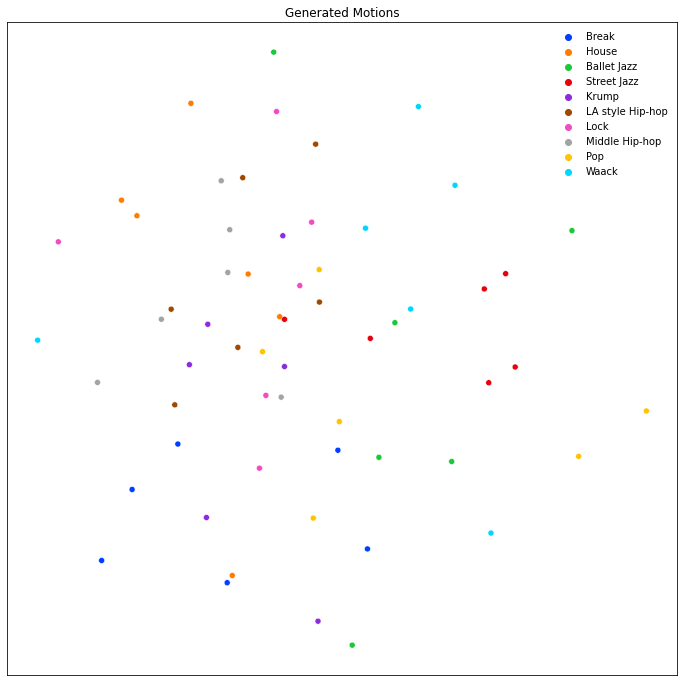

In [105]:
plt.figure(figsize = (12,12))
g1 = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = musics, palette = "bright" , legend = True)
g1.set(title='Generated Motions')
g1.set(xticklabels=[])
g1.set(xlabel=None)
g1.set(yticklabels=[])
g1.set(ylabel=None)
plt.legend( frameon=False)
plt.tick_params(bottom=False , left = False) 
plt.show()

In [147]:
save_pth = "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/generator/var_len/trans_768_768_albi_aist/"

In [154]:
musics = glob("/srv/scratch/sanisetty3/music_motion/AIST/music/*")
for music_path in musics:
    

    # music_name = str(reg_batch["names"]).split("_")[-2]
    music_encoding=  np.load(os.path.join(music_path))
    music_name = os.path.basename(music_path).split(".")[0]
    print(music_name)
    motion_indices_path = get_motion(music_name)
    gt_motion_indices = torch.LongTensor(np.load(motion_indices_path))[None,...]
    gen_motion_indices = inp[:,:1]
    while gen_motion_indices.shape[1]<=400:
        gen_motion_indices = trans_model.generate(start_tokens =gen_motion_indices.cuda(),\
                                              seq_len=400 , \
                                              context = torch.Tensor(music_encoding)[None,...].cuda(), \
                                            context_mask=torch.ones((1 ,music_encoding.shape[0]) , dtype = torch.bool).cuda()
                                              )
        gen_motion_indices = gen_motion_indices[gen_motion_indices<1024][None,...]
        print(gen_motion_indices.shape[1])
        
    
    quant , out_motion = vqvae_model.decode(gen_motion_indices.cuda())
    np.save(os.path.join(save_pth , music_name+".npy" ,) , out_motion.cpu().numpy())

    sample_render(to_xyz(out_motion[0:1].detach().cpu(),mean = train_ds.mean , std = train_ds.std), name = music_name+"" , save_path = save_pth)
    
    quant , out_motion = vqvae_model.decode(gt_motion_indices.cuda())
    sample_render(to_xyz(out_motion[0:1].detach().cpu(),mean = train_ds.mean , std = train_ds.std), name = music_name+"_gt" , save_path = save_pth)
    
    gt_motion_indices

mWA0


100%|██████████| 400/400 [00:08<00:00, 44.88it/s]


401
render start
render start
mHO0


100%|██████████| 400/400 [00:08<00:00, 44.96it/s]


401
render start
render start
mJB0


100%|██████████| 400/400 [00:08<00:00, 44.89it/s]


401
render start
render start
mMH0


100%|██████████| 400/400 [00:08<00:00, 44.95it/s]


401
render start
render start
mPO0


100%|██████████| 400/400 [00:08<00:00, 44.88it/s]


401
render start
render start
mJS0


100%|██████████| 400/400 [00:08<00:00, 44.90it/s]


401
render start
render start
mBR3


100%|██████████| 400/400 [00:08<00:00, 44.92it/s]


401
render start
render start
mBR4


100%|██████████| 400/400 [00:08<00:00, 44.91it/s]


401
render start
render start
mLH0


100%|██████████| 400/400 [00:08<00:00, 44.88it/s]


401
render start
render start
mLO2


100%|██████████| 400/400 [00:08<00:00, 44.94it/s]


401
render start
render start
mKR1


100%|██████████| 400/400 [00:08<00:00, 44.90it/s]


401
render start
render start
mLO5


100%|██████████| 400/400 [00:08<00:00, 44.63it/s]


401
render start
render start
mMH1


100%|██████████| 400/400 [00:08<00:00, 44.93it/s]


401
render start
render start
mPO1


100%|██████████| 400/400 [00:08<00:00, 44.88it/s]


401
render start
render start
mJB1


100%|██████████| 400/400 [00:09<00:00, 42.15it/s]


401
render start
render start
mHO1


100%|██████████| 400/400 [00:08<00:00, 44.85it/s]


401
render start
render start
mWA1


100%|██████████| 400/400 [00:08<00:00, 45.02it/s]


401
render start
render start
mKR0


100%|██████████| 400/400 [00:08<00:00, 45.10it/s]


401
render start
render start
mLO4


100%|██████████| 400/400 [00:08<00:00, 45.00it/s]


401
render start
render start
mLO3


100%|██████████| 400/400 [00:08<00:00, 44.94it/s]


401
render start
render start
mLH1


100%|██████████| 400/400 [00:08<00:00, 44.94it/s]


401
render start
render start
mBR5


100%|██████████| 400/400 [00:08<00:00, 45.49it/s]


401
render start
render start
mJS1


100%|██████████| 400/400 [00:08<00:00, 45.05it/s]


401
render start
render start
mBR2


100%|██████████| 400/400 [00:08<00:00, 45.05it/s]


401
render start
render start
mKR4


100%|██████████| 400/400 [00:08<00:00, 44.90it/s]


401
render start
render start
mLO0


100%|██████████| 400/400 [00:08<00:00, 44.47it/s]


401
render start
render start
mKR3


100%|██████████| 400/400 [01:05<00:00,  6.12it/s]


401
render start
render start
mLH5


100%|██████████| 400/400 [01:06<00:00,  6.00it/s]


401
render start
render start
mLH2


100%|██████████| 400/400 [01:05<00:00,  6.13it/s]


401
render start
render start
mBR1


100%|██████████| 400/400 [01:05<00:00,  6.09it/s]


401
render start
render start
mJS2


100%|██████████| 400/400 [01:05<00:00,  6.13it/s]


401
render start
render start
mJS5


100%|██████████| 400/400 [01:05<00:00,  6.10it/s]


401
render start
render start
mPO5


100%|██████████| 400/400 [01:05<00:00,  6.14it/s]


401
render start
render start
mMH5


100%|██████████| 400/400 [01:05<00:00,  6.15it/s]


401
render start
render start
mJB2


100%|██████████| 400/400 [00:26<00:00, 15.38it/s]


401
render start
render start
mJB5


100%|██████████| 400/400 [00:14<00:00, 28.05it/s]


401
render start
render start
mMH2


100%|██████████| 400/400 [00:08<00:00, 45.11it/s]


401
render start
render start
mPO2


100%|██████████| 400/400 [00:08<00:00, 45.03it/s]


401
render start
render start
mHO2


100%|██████████| 400/400 [00:08<00:00, 44.99it/s]


401
render start
render start
mHO5


100%|██████████| 400/400 [00:08<00:00, 44.89it/s]


401
render start
render start
mWA5


100%|██████████| 400/400 [00:08<00:00, 45.38it/s]


401
render start
render start
mWA2


100%|██████████| 400/400 [00:08<00:00, 45.04it/s]


401
render start
render start
mJS4


100%|██████████| 400/400 [00:08<00:00, 45.03it/s]


401
render start
render start
mBR0


100%|██████████| 400/400 [00:09<00:00, 41.40it/s]


401
render start
render start
mJS3


100%|██████████| 400/400 [00:08<00:00, 44.98it/s]


401
render start
render start
mLH3


100%|██████████| 400/400 [00:09<00:00, 41.79it/s]


401
render start
render start
mLH4


100%|██████████| 400/400 [00:08<00:00, 45.33it/s]


401
render start
render start
mKR2


100%|██████████| 400/400 [00:14<00:00, 27.65it/s]


401
render start
render start
mKR5


100%|██████████| 400/400 [00:14<00:00, 27.21it/s]


401
render start
render start
mLO1


100%|██████████| 400/400 [00:14<00:00, 27.35it/s]


401
render start
render start
mWA3


100%|██████████| 400/400 [00:14<00:00, 27.26it/s]


401
render start
render start
mWA4


100%|██████████| 400/400 [00:08<00:00, 44.97it/s]


401
render start
render start
mHO4


100%|██████████| 400/400 [00:08<00:00, 44.99it/s]


401
render start
render start
mHO3


100%|██████████| 400/400 [00:08<00:00, 44.99it/s]


401
render start
render start
mMH3


100%|██████████| 400/400 [00:08<00:00, 44.93it/s]


401
render start
render start
mJB4


100%|██████████| 400/400 [00:08<00:00, 44.87it/s]


401
render start
render start
mPO3


100%|██████████| 400/400 [00:08<00:00, 44.78it/s]


401
render start
render start
mPO4


100%|██████████| 400/400 [00:08<00:00, 45.25it/s]


401
render start
render start
mJB3


100%|██████████| 400/400 [00:08<00:00, 44.87it/s]


401
render start
render start
mMH4


100%|██████████| 400/400 [00:08<00:00, 45.01it/s]


401
render start
render start


In [35]:
processed_gen_output = process_gen_output(gen_motion_indices[0] , 400)

In [36]:
processed_gen_output.shape

torch.Size([119])

In [114]:
quant , out_motion = vqvae_model.decode(gen_motion_indices.cuda())
sample_render(to_xyz(out_motion[0:1].detach().cpu(),mean = train_ds.mean , std = train_ds.std), "rnd_motion" , "/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/decode_test")

render start


## Evaluate Generative

In [1]:
from configs.config import cfg, get_cfg_defaults
from core.models.vqvae import VQMotionModel
from core.models.motion_regressor import MotionRegressorModel

cfg_vq = get_cfg_defaults()
cfg_vq.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/configs/var_len_768_768_aist_vq.yaml")


cfg_trans = get_cfg_defaults()
cfg_trans.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/generator/var_len/trans_768_768_albi_aist/var_len_768_768_aist.yaml")



In [2]:
from utils.eval_music import evaluate_music_motion_vqvae, evaluate_music_motion_generative2, evaluate_music_motion_generative,evaluate_music_motion_trans

In [6]:
aist_ds = VQFullMotionDataset("aist", split = "train" , data_root = "/srv/scratch/sanisetty3/music_motion/AIST" , window_size = -1)
aist_loader = DATALoader(aist_ds,1,collate_fn=None)

100%|██████████| 40/40 [00:00<00:00, 43.59it/s]

Total number of motions 40


In [8]:
trans_model = MotionRegressorModel(args = cfg_trans.motion_trans ,pad_value=1025 ).eval()
pkg_trans = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/generator/var_len/trans_768_768_albi_aist/trans_motion_best_fid.pt", map_location = 'cpu')
print(pkg_trans["steps"])
trans_model.load_state_dict(pkg_trans["model"])
trans_model =trans_model.cuda()


tensor([195000.])


In [9]:
vqvae_model = VQMotionModel(cfg_vq.vqvae).eval()
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768_mix/vqvae_motion_best_fid.pt", map_location = 'cpu')
print(pkg["steps"])
vqvae_model.load_state_dict(pkg["model"])
vqvae_model =vqvae_model.cuda()


tensor([295000.])


In [13]:
a,b,c,d,e = evaluate_music_motion_generative(aist_loader , vqvae_model= vqvae_model ,net = trans_model)


  2%|▎         | 1/40 [00:13<08:44, 13.45s/it]

(213, 22, 3)
(213, 22, 3)


  5%|▌         | 2/40 [00:23<07:13, 11.40s/it]

(239, 22, 3)
(239, 22, 3)


  8%|▊         | 3/40 [00:36<07:26, 12.06s/it]

(191, 22, 3)
(191, 22, 3)


 10%|█         | 4/40 [00:50<07:48, 13.02s/it]

(191, 22, 3)
(191, 22, 3)


 12%|█▎        | 5/40 [01:04<07:46, 13.33s/it]

(141, 22, 3)
(141, 22, 3)


 15%|█▌        | 6/40 [01:17<07:30, 13.26s/it]

(141, 22, 3)
(141, 22, 3)


 18%|█▊        | 7/40 [01:32<07:38, 13.89s/it]

(239, 22, 3)
(239, 22, 3)


 20%|██        | 8/40 [01:47<07:33, 14.16s/it]

(159, 22, 3)
(159, 22, 3)


 22%|██▎       | 9/40 [02:01<07:15, 14.05s/it]

(147, 22, 3)
(147, 22, 3)


 25%|██▌       | 10/40 [02:15<07:02, 14.09s/it]

(191, 22, 3)
(191, 22, 3)


 28%|██▊       | 11/40 [02:29<06:44, 13.93s/it]

(159, 22, 3)
(159, 22, 3)


 30%|███       | 12/40 [02:43<06:36, 14.17s/it]

(213, 22, 3)
(213, 22, 3)


 32%|███▎      | 13/40 [02:58<06:24, 14.23s/it]

(239, 22, 3)
(239, 22, 3)


 35%|███▌      | 14/40 [03:11<06:02, 13.95s/it]

(174, 22, 3)
(174, 22, 3)


 38%|███▊      | 15/40 [03:20<05:11, 12.45s/it]

(239, 22, 3)
(239, 22, 3)


 40%|████      | 16/40 [03:29<04:32, 11.36s/it]

(239, 22, 3)
(239, 22, 3)


 42%|████▎     | 17/40 [03:38<04:02, 10.54s/it]

(191, 22, 3)
(191, 22, 3)


 45%|████▌     | 18/40 [03:46<03:36,  9.86s/it]

(159, 22, 3)
(159, 22, 3)


 48%|████▊     | 19/40 [03:54<03:15,  9.31s/it]

(174, 22, 3)
(174, 22, 3)


 50%|█████     | 20/40 [04:02<03:01,  9.10s/it]

(174, 22, 3)
(174, 22, 3)


 52%|█████▎    | 21/40 [04:11<02:47,  8.82s/it]

(174, 22, 3)
(174, 22, 3)


 55%|█████▌    | 22/40 [04:19<02:38,  8.79s/it]

(191, 22, 3)
(191, 22, 3)


 57%|█████▊    | 23/40 [04:28<02:28,  8.71s/it]

(174, 22, 3)
(174, 22, 3)


 60%|██████    | 24/40 [04:37<02:19,  8.73s/it]

(239, 22, 3)
(239, 22, 3)


 62%|██████▎   | 25/40 [04:45<02:10,  8.69s/it]

(191, 22, 3)
(191, 22, 3)


 65%|██████▌   | 26/40 [04:54<02:02,  8.74s/it]

(191, 22, 3)
(191, 22, 3)


 68%|██████▊   | 27/40 [05:02<01:51,  8.60s/it]

(147, 22, 3)
(147, 22, 3)


 70%|███████   | 28/40 [05:11<01:42,  8.57s/it]

(174, 22, 3)
(174, 22, 3)


 72%|███████▎  | 29/40 [05:19<01:32,  8.45s/it]

(174, 22, 3)
(174, 22, 3)


 75%|███████▌  | 30/40 [05:28<01:25,  8.50s/it]

(239, 22, 3)
(239, 22, 3)


 78%|███████▊  | 31/40 [05:36<01:17,  8.59s/it]

(213, 22, 3)
(213, 22, 3)


 80%|████████  | 32/40 [05:45<01:09,  8.69s/it]

(239, 22, 3)
(239, 22, 3)


 82%|████████▎ | 33/40 [05:54<01:00,  8.59s/it]

(147, 22, 3)
(147, 22, 3)


 85%|████████▌ | 34/40 [06:02<00:51,  8.54s/it]

(174, 22, 3)
(174, 22, 3)


 88%|████████▊ | 35/40 [06:11<00:43,  8.62s/it]

(213, 22, 3)
(213, 22, 3)


 90%|█████████ | 36/40 [06:19<00:33,  8.47s/it]

(147, 22, 3)
(147, 22, 3)


 92%|█████████▎| 37/40 [06:27<00:25,  8.40s/it]

(141, 22, 3)
(141, 22, 3)


 95%|█████████▌| 38/40 [06:36<00:16,  8.44s/it]

(191, 22, 3)
(191, 22, 3)


 98%|█████████▊| 39/40 [06:44<00:08,  8.45s/it]

(141, 22, 3)
(141, 22, 3)


100%|██████████| 40/40 [06:53<00:00, 10.33s/it]

(159, 22, 3)
(159, 22, 3)
FID_k:  10.01591244900564 Diversity_k: 10.072333861467166
FID_g:  18.79016723107179 Diversity_g: 6.628105337191851

Beat score on real data: 0.244


Beat score on generated data: 0.218

\PFC score on real data: 5.249

\PFC score on generated data: 0.315



In [ ]:
a,b,c,d,e,f,g= evaluate_music_motion_generative2(aist_loader , vqvae_model= vqvae_model ,net = trans_model , seq_len = 100)
